# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [2]:
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
#path = '~/scratch work/Yuqing-Data-Merge/Data/dt'

In [4]:
df = pd.read_csv('dfnlf.csv')

# Drop first column
df.drop(columns=df.columns[0], 
        axis=1, 
        inplace=True)
df 


,ds,y,fbsp,tby,ffr,fta,eps,div,une,wti,ppi,rfs,fbsp_tby,fbsp_ffr,fbsp_div,eps_tby,eps_ffr,eps_div
0,2009-01-28,874.09,775.368737,2.71,0.15,1927437.0,18.75,3.23,7.8,42.04,171.2,336929.0,2101.249277,116.305311,2504.441020,50.8125,2.8125,60.5625
1,2009-01-29,845.14,771.778314,2.87,0.15,1927437.0,18.75,3.23,7.8,41.58,171.2,336929.0,2215.003762,115.766747,2492.843955,53.8125,2.8125,60.5625
2,2009-01-30,825.88,769.800284,2.87,0.15,1927437.0,18.75,3.23,7.8,41.73,171.2,336929.0,2209.326816,115.470043,2486.454919,53.8125,2.8125,60.5625
3,2009-02-02,825.44,774.798116,2.76,0.22,1927437.0,15.31,3.24,8.3,41.35,169.3,335576.0,2138.442800,170.455585,2510.345896,42.2556,3.3682,49.6044
4,2009-02-03,838.51,772.782361,2.89,0.22,1927437.0,15.31,3.24,8.3,40.87,169.3,335576.0,2233.341023,170.012119,2503.814849,44.2459,3.3682,49.6044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2761,2020-02-21,3337.75,3176.089345,1.46,1.58,4171570.0,135.28,1.79,3.5,53.36,196.7,525810.0,4637.090444,5018.221166,5685.199928,197.5088,213.7424,242.1512
2762,2020-02-24,3225.89,3177.664932,1.38,1.58,4171570.0,135.28,1.79,3.5,51.36,196.7,525810.0,4385.177607,5020.710593,5688.020229,186.6864,213.7424,242.1512
2763,2020-02-25,3128.21,3179.642531,1.33,1.58,4171570.0,135.28,1.79,3.5,49.78,196.7,525810.0,4228.924567,5023.835200,5691.560131,179.9224,213.7424,242.1512
2764,2020-02-26,3116.39,3181.017180,1.33,1.58,4158637.0,135.28,1.79,3.5,48.67,196.7,525810.0,4230.752849,5026.007144,5694.020752,179.9224,213.7424,242.1512


In [5]:
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)

df_train = df[:cutoff].copy()
df_test = df[cutoff:].copy()

In [8]:
df.columns

Index(['ds', 'y', 'fbsp', 'tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti',
       'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby', 'eps_ffr',
       'eps_div'],
      dtype='object')

In [9]:
#per removed

possible_features = ['tby', 'ffr', 'fta', 'eps', 'div', 'une',
       'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_tby',
       'eps_ffr', 'eps_div']

from itertools import chain, combinations

def powerset(iterable):
    #"powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


#print(list(powerset(possible_features)))

In [10]:
from statsmodels.regression.linear_model import OLS

reg_new = OLS((df_train['y'] - df_train.fbsp).copy(),df_train[possible_features].copy()).fit()
print(reg_new.params)

#from the output, we can see it's consistent with sklearn output

tby         113.155021
ffr        -354.268092
fta           0.000145
eps          -5.283115
div         123.563354
une         -64.346948
wti           2.483658
ppi          -7.610912
rfs           0.006036
fbsp_tby     -0.044951
fbsp_ffr     -0.270453
fbsp_div     -0.440890
eps_tby      -0.150535
eps_ffr       9.889997
eps_div       2.037234
dtype: float64


In [11]:
new_coef = reg_new.params
new_possible_feats = new_coef[abs(new_coef)>0].index

power_feats = list(powerset(new_possible_feats))
power_feats.remove(())

power_feats = [ list(feats) for feats in power_feats]
power_feats 


[['tby'],
 ['ffr'],
 ['fta'],
 ['eps'],
 ['div'],
 ['une'],
 ['wti'],
 ['ppi'],
 ['rfs'],
 ['fbsp_tby'],
 ['fbsp_ffr'],
 ['fbsp_div'],
 ['eps_tby'],
 ['eps_ffr'],
 ['eps_div'],
 ['tby', 'ffr'],
 ['tby', 'fta'],
 ['tby', 'eps'],
 ['tby', 'div'],
 ['tby', 'une'],
 ['tby', 'wti'],
 ['tby', 'ppi'],
 ['tby', 'rfs'],
 ['tby', 'fbsp_tby'],
 ['tby', 'fbsp_ffr'],
 ['tby', 'fbsp_div'],
 ['tby', 'eps_tby'],
 ['tby', 'eps_ffr'],
 ['tby', 'eps_div'],
 ['ffr', 'fta'],
 ['ffr', 'eps'],
 ['ffr', 'div'],
 ['ffr', 'une'],
 ['ffr', 'wti'],
 ['ffr', 'ppi'],
 ['ffr', 'rfs'],
 ['ffr', 'fbsp_tby'],
 ['ffr', 'fbsp_ffr'],
 ['ffr', 'fbsp_div'],
 ['ffr', 'eps_tby'],
 ['ffr', 'eps_ffr'],
 ['ffr', 'eps_div'],
 ['fta', 'eps'],
 ['fta', 'div'],
 ['fta', 'une'],
 ['fta', 'wti'],
 ['fta', 'ppi'],
 ['fta', 'rfs'],
 ['fta', 'fbsp_tby'],
 ['fta', 'fbsp_ffr'],
 ['fta', 'fbsp_div'],
 ['fta', 'eps_tby'],
 ['fta', 'eps_ffr'],
 ['fta', 'eps_div'],
 ['eps', 'div'],
 ['eps', 'une'],
 ['eps', 'wti'],
 ['eps', 'ppi'],
 ['eps', 'r

In [12]:
AIC_scores = []
parameters = []

for feats in power_feats:
    tmp_reg = OLS((df_train['y'] - df_train.fbsp).copy(),df_train[feats].copy()).fit()
    AIC_scores.append(tmp_reg.aic)
    parameters.append(tmp_reg.params)

    
Min_AIC_index = AIC_scores.index(min(AIC_scores))
Min_AIC_feats = power_feats[Min_AIC_index]  
Min_AIC_params  = parameters[Min_AIC_index]
print(Min_AIC_feats)
print(Min_AIC_params)  

['tby', 'ffr', 'fta', 'eps', 'div', 'une', 'wti', 'ppi', 'rfs', 'fbsp_tby', 'fbsp_ffr', 'fbsp_div', 'eps_ffr', 'eps_div']
tby         102.206252
ffr        -361.662556
fta           0.000148
eps          -5.842231
div         119.848326
une         -62.956678
wti           2.463659
ppi          -7.475417
rfs           0.006059
fbsp_tby     -0.047147
fbsp_ffr     -0.276491
fbsp_div     -0.438098
eps_ffr      10.095170
eps_div       2.030231
dtype: float64


In [13]:
###After selecting the best features, we report the testing error, and make the plot 
AIC_df_test = df_test[Min_AIC_feats]
AIC_pred_test = AIC_df_test.dot(Min_AIC_params)+df_test.fbsp

AIC_df_train = df_train[Min_AIC_feats]
AIC_pred_train = AIC_df_train.dot(Min_AIC_params)+ df_train.fbsp



In [14]:
from sklearn.metrics import mean_squared_error as MSE

mse_train = MSE(df_train.y, AIC_pred_train) 
mse_test = MSE(df_test.y, AIC_pred_test)


#compare with fbprophet()

fb_mse_train = MSE(df_train.y, df_train.fbsp) 
fb_mse_test = MSE(df_test.y, df_test.fbsp)


print(mse_train,mse_test)

print(fb_mse_train,fb_mse_test)

2092.425487052955 30191.86530176508
18536.638305640623 30385.834822789413


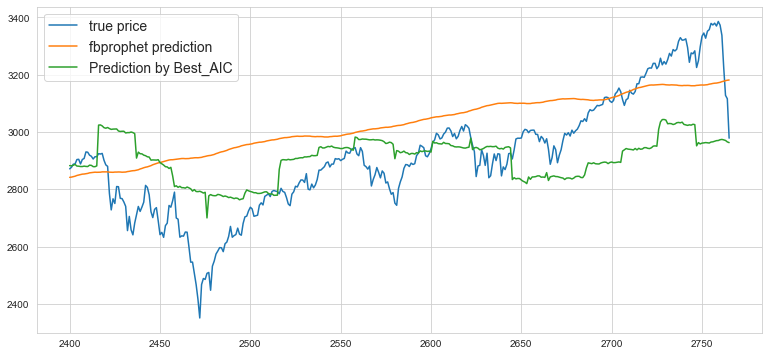

In [15]:
plt.figure(figsize=(13,6))
plt.plot(df_test.y,label="true price")
plt.plot(df_test.fbsp,label="fbprophet prediction")
plt.plot(AIC_pred_test,label="Prediction by Best_AIC")
plt.legend(fontsize = 14)
plt.show()